# Import Libraries

In [4]:
import sys
sys.path.append('..')
for p in sys.path:
    print(p)

/Users/isosnovik/Developer/map-generalization-thesis-2021/notebooks
/Users/isosnovik/.vscode/extensions/ms-toolsai.jupyter-2021.3.619093157/pythonFiles/vscode_datascience_helpers/../.does-not-exist
/Users/isosnovik/.vscode/extensions/ms-toolsai.jupyter-2021.3.619093157/pythonFiles
/Users/isosnovik/.vscode/extensions/ms-toolsai.jupyter-2021.3.619093157/pythonFiles/lib/python
/Users/isosnovik/miniconda3/lib/python37.zip
/Users/isosnovik/miniconda3/lib/python3.7
/Users/isosnovik/miniconda3/lib/python3.7/lib-dynload

/Users/isosnovik/miniconda3/lib/python3.7/site-packages
/Users/isosnovik/miniconda3/lib/python3.7/site-packages/yacs-0.1.8-py3.7.egg
/Users/isosnovik/miniconda3/lib/python3.7/site-packages/e2cnn-0.1.5-py3.7.egg
/Users/isosnovik/miniconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg
/Users/isosnovik/miniconda3/lib/python3.7/site-packages/IPython/extensions
/Users/isosnovik/.ipython
..
..
..


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
#import mapbox_vector_tile
from time import time
import operator
from collections import Counter
import json
import os
import math
import random

from tensorflow.keras import Sequential
from tensorflow.keras import layers

from shapely import geometry 
import geopandas as gpd
from simplification.cutil import (
    simplify_coords,
    simplify_coords_idx,
    simplify_coords_vw,
    simplify_coords_vw_idx,
    simplify_coords_vwp,
)

OSError: Could not find lib c or load any of its variants [].

# Define Functions

In [451]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    try:
        conn = sqlite3.connect(db_file)
        print(conn)
    except Error as e:
        print(e)
    
    return conn

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def ScoreFormula(old_number_of_datapoints, new_number_of_datapoints, processing_time):
    return (1 - (new_number_of_datapoints / old_number_of_datapoints)) * (1 - processing_time)


def ScaleFactor(all_geometries):
    b_list = []
    
    for geometries in all_geometries:
        
        polygon = geometry.Polygon(geometries)
        centroid = np.array(polygon.centroid)
        coordinates = np.vstack(geometries)
        
        b = coordinates - centroid
        b_min = np.min(b)
        b_max = np.max(b)
        b_list.append(b_min)
        b_list.append(b_max)
        
    return np.std(b_list)
    
def Normalize_Geometry(coordinates1, scale_factor):
    polygon = geometry.Polygon(coordinates1)
    centroid = np.array(polygon.centroid)
    coordinates2 = np.vstack(coordinates1)
    
    return (coordinates2 - centroid) / scale_factor

def Add_One_Hot(normalized_geometry):
    normalized_geometry = np.insert(normalized_geometry, 2, 1, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 3, 0, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 4, 0, axis=1)
    normalized_geometry[len(normalized_geometry)-1,2] = 0
    normalized_geometry[len(normalized_geometry)-1,4] = 1
    
    return normalized_geometry

def Add_Zero_Padding(one_hotted_geometry, max_length):
    boundary = max_length - len(one_hotted_geometry)
    zero_matrix = np.zeros([boundary,5])
    return np.append(one_hotted_geometry, zero_matrix, axis=0)

def CreateGrid(poly, dx, dy):
    
    x_ls = []
    y_ls = []

    for a in poly:
        x_ls.append(a[0])
    for a in poly:
        y_ls.append(a[1])
        
    minx = min(x_ls)
    maxx = max(x_ls)
    miny = min(y_ls)
    maxy = max(y_ls)

    nx = int(math.ceil(abs(maxx - minx)/dx))
    ny = int(math.ceil(abs(maxy - miny)/dy))

    grid = []       
    for i in range(ny):   
        grid.append(geometry.LineString([[minx,max(maxy-dy*i,miny)], [maxx, max(maxy-dy*i,miny)]]))

    for j in range(nx):
        grid.append(geometry.LineString([[min(minx+dx*j,maxx), maxy], [min(minx+dx*j,maxx), miny]]))
    
    return grid
    
def CheckSameIntersections(poly, simplified_coords, grid, ROUNDING):
    
    original = geometry.Polygon(poly)
    simplified = geometry.Polygon(simplified_coords)

    o_ls = []
    s_ls = []
    for line in grid:
        x = original.intersection(line)
        y = simplified.intersection(line)
        if x:
            if x.geom_type == 'Point':
                o_ls.append(hash(tuple([round(x.coords[0][0],ROUNDING), round(x.coords[0][1],ROUNDING)])))
            if x.geom_type == 'LineString':
                for xy in x.coords:
                    o_ls.append(hash(tuple([round(xy[0],ROUNDING), round(xy[1],ROUNDING)])))
    
        if y:
            if y.geom_type == 'Point':
                s_ls.append(hash(tuple([round(y.coords[0][0],ROUNDING), round(y.coords[0][1],ROUNDING)])))
            if y.geom_type == 'LineString':
                for xy in y.coords:
                    s_ls.append(hash(tuple([round(xy[0],ROUNDING), round(xy[1],ROUNDING)])))
        
    return len(list(set(o_ls).intersection(s_ls))) / len(set(o_ls))

grid = CreateGrid(length_list[58][0], dx, dy)
CheckSameIntersections(length_list[58][0], simplify_coords_vw(length_list[58][0], 
                                                              simplify_possibilities[1][1]),grid, ROUNDING)
#print(len(test))

0.652232746955345

# Load Data

## Pand Centrum

In [35]:
conn_pand_centrum = create_connection("/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/SQLite/Pand_26116_centrum.db")

cur = conn_pand_centrum.cursor()
cur.execute("SELECT data FROM tiles;")

rows = cur.fetchall()
pand_centrum_data = []
for row in rows:
    pand_centrum_data.append(mapbox_vector_tile.decode(row[0]))
    #print(row[0])
print(len(pand_centrum_data))

56188


## Wegdeel Buiten

In [25]:
conn_wegdeel_buiten = create_connection("/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/SQLite/Wegdeel_23770_buitengebied.db")

cur = conn_wegdeel_buiten.cursor()
cur.execute("SELECT data FROM tiles;")

rows = cur.fetchall()
wegdeel_buiten_data = []
for row in rows:
    wegdeel_buiten_data.append(mapbox_vector_tile.decode(row[0]))

In [10]:
path = '/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/Source/'
Polygons = []

for filename in os.listdir(path):
    if "vlakgeometrie2d" in filename:
        
        f = open(str(path + filename))
        wegdeeljson = json.load(f)

        for a in wegdeeljson['features']:
            Polygons.append(a['geometry']['coordinates'][0])
    
    
    

#f = open('/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/Source/Wegdeel_23770_buitengebied_vlakgeometrie2d.json')
#wegdeeljson = json.load(f)
#wegdeeljson



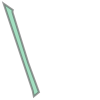

In [39]:
geometry.Polygon(wegdeeljson['features'][5]['geometry']['coordinates'][0])


In [46]:
#wegdeel_buiten_data[0:4]

[<shapely.geometry.polygon.Polygon object at 0x7fb22d34c390>, <shapely.geometry.polygon.Polygon object at 0x7fb22d33c7d0>, <shapely.geometry.polygon.Polygon object at 0x7fb22d34c150>, <shapely.geometry.polygon.Polygon object at 0x7fb22d34cd50>, <shapely.geometry.polygon.Polygon object at 0x7fb22d34c350>]


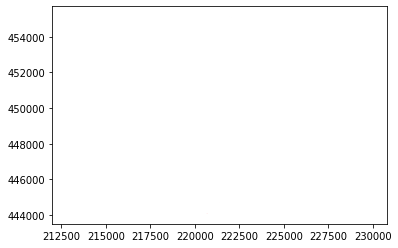

In [19]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt

ls = []
for a in wegdeeljson['features'][:5]:
    ls.append(geometry.Polygon(a['geometry']['coordinates'][0]))

new_shape = so.cascaded_union(ls)
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=1, fc='r', ec='none')

plt.show()

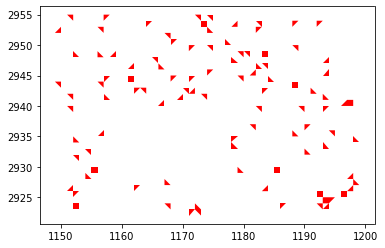

In [45]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt


ls = []
for element in wegdeel_buiten_data[3]['wegdeel.se_fld15_vlakgeometrie2d']['features']:
    
    #print(element['geometry']['coordinates'][0])
    #geometry.Polygon(element['geometry']['coordinates'][0])
    element2 = element['geometry']
    
    if element2['type'] == 'MultiPolygon':
        if element2['coordinates']:
            for poly in element2['coordinates'][0]:
                print(poly)
                ls.append(geometry.Polygon(poly))
    
    else:
        ls.append(geometry.Polygon(element['geometry']['coordinates'][0]))

#r1 = sg.Polygon([[243, 2760], [242, 2760], [242, 2761], [243, 2760]])
#r2 = sg.Polygon([[243, 2759], [243, 2760], [244, 2760], [244, 2759], [243, 2759]])
#r3 = sg.Polygon([[244, 2759], [243, 2759], [243, 2760], [244, 2760], [244, 2759]])
#r4 = sg.Polygon([[243, 2759], [242, 2759], [242, 2760], [243, 2760], [243, 2759]])
#r5 = sg.Polygon([[241, 2759], [241, 2760], [242, 2759], [241, 2759]])

new_shape = so.cascaded_union(ls)
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=1, fc='r', ec='none')

plt.show()

# Pre Processing

## Parameters

In [433]:
# Simplification Possibilities
simplify_possibilities = [['D-P', 0], ['D-P', 0.5], ['D-P', 0.1], ['D-P', 0.05], ['D-P', 0.01], ['D-P', 0.005], 
                          ['D-P', 0.001], ['V-W', 0.5], ['V-W', 0.1], ['V-W', 0.05], ['V-W', 0.01], 
                          ['V-W', 0.005], ['V-W', 0.001], ['V-W', 0.0005], ['V-W', 0.0001], ['V-W', 0.00005]]

# Polygon length evaluation
MAX_LENGTH_DEFICIT = -0.1

# Grid
dx = 1
dy = 1
ROUNDING = 1

MIN_INTERSECTIONS_PERC = 0.75

In [ ]:
Lines = []
Polygons = []
MultiPolygons = []
a=0
for row in pand_centrum_data[:10000]:
    print(str(a) + " / " + str(len(pand_centrum_data)), end="\r")
    a = a + 1
    keys = row.keys()
    
    for key in keys:
        for element in row[key]['features']:
            
            if element['geometry']['type'] == 'LineString': 
                Lines.append(element['geometry']['coordinates'])
            
            if element['geometry']['type'] == 'Polygon':
                Polygons.append(element['geometry']['coordinates'][0])
                
            #if element['geometry']['type'] == 'MultiPolygon':
                #MultiPolygons.append(element['geometry']['coordinates'])
    
    

#test = lvl10_data[0]['spoor.se_fld12_lijngeometrie2d']['features'][0]['geometry']['coordinates']
#print(Polygons)

In [26]:
Lines = []
Polygons = []
MultiPolygons = []
a=0
for row in wegdeel_buiten_data:
    print(str(a) + " / " + str(len(wegdeel_buiten_data)), end="\r")
    a = a + 1
    keys = row.keys()
    
    for key in keys:
        for element in row[key]['features']:
            
            if element['geometry']['type'] == 'LineString': 
                Lines.append(element['geometry']['coordinates'])
            
            if element['geometry']['type'] == 'Polygon':
                Polygons.append(element['geometry']['coordinates'][0])
                
            if element['geometry']['type'] == 'MultiPolygon':
                if element['geometry']['coordinates']:
                    for poly in element['geometry']['coordinates'][0]:
                        MultiPolygons.append(poly)
    
    

#test = lvl10_data[0]['spoor.se_fld12_lijngeometrie2d']['features'][0]['geometry']['coordinates']
#print(Polygons)

In [31]:
#print(len(Lines))
print(len(Polygons))
#print(len(MultiPolygons))

ls = []
for a in Polygons:
    ls.append(len(a))
    
pd.DataFrame({'lengths':Counter(ls).keys(),
              'freq':Counter(ls).values()})

23770


,lengths,freq
0,12,678
1,16,451
2,18,368
3,9,1269
4,11,834
...,...,...
297,302,2
298,427,1
299,393,1
300,276,1


In [340]:
list1 = [1,2,3,4,5,6]
list2 = [3, 5, 7, 9]
list(set(list1).intersection(list2))

{3, 5}

In [307]:


CheckSameIntersections(Polygons[10],dx, dy, ROUNDING, 0.01)

1.0

28
27
1.0


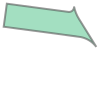

In [393]:
c = 110
t = 0.001

print(len(Polygons[c]))
print(len(simplify_coords(Polygons[c],t)))
print(CheckSameIntersections(Polygons[c],dx, dy, ROUNDING, t))
geometry.Polygon(simplify_coords(Polygons[c], t))

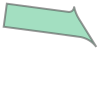

In [389]:
geometry.Polygon(Polygons[c])

In [439]:
print(len(length_list[58][0]))
len(simplify_coords(length_list[58][0], 0.5))

421


74

In [460]:
results_list = []
length_list = []
Polygons_sample = random.sample(Polygons, 25000)
scale_factor = ScaleFactor(Polygons_sample)
print("Scale Factor done")


# Decide order from longest polygon to smallest polygon
for row in Polygons_sample:

    length_list.append([row, len(row)])

length_list.sort(key=operator.itemgetter(1), reverse=True)
print("Sorted the Polygons")
a=0
for element in length_list:
    print(str(a) + " / " + str(len(length_list)), end="\r")
    a = a + 1
    results_dict = {}
    poly1 = geometry.Polygon(element[0])
    results = []
    grid = CreateGrid(element[0], dx, dy)
    
    for possibility in simplify_possibilities:
        

        if possibility[0] == 'D-P':
            # Simplification function Douglas-Peucker
            time_start = time()
            simplified_coordinates = simplify_coords(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start

        if possibility[0] == 'V-W':
            # Simplification function Visvalingam-Whyatt
            time_start = time()
            simplified_coordinates = simplify_coords_vw(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start
        
        
        if len(simplified_coordinates) >= 3:
            poly2 = geometry.Polygon(simplified_coordinates)
            length_deficit = (poly2.length - poly1.length) / poly1.length
        
            # If the length deficit of the polygon is smaller(greater) than the provided MAX_LENGTH_DEFICIT, 
            # the score gets saved
            #if length_deficit > MAX_LENGTH_DEFICIT:
            
            if length_deficit == 0:
                score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
                results.append(score)
                continue
                
            try:
                if CheckSameIntersections(element[0], simplified_coordinates, grid, ROUNDING) > MIN_INTERSECTIONS_PERC:
                    score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
                    results.append(score)
            except Exception:
                continue
    
    results_dict['polygon'] = Add_Zero_Padding(Add_One_Hot(Normalize_Geometry(element[0], scale_factor)), len(length_list[0][0]))
    results_dict['algorithm'] = results.index(max(results))
    results_list.append(results_dict)

X = []
y = []
a = 0
for element in results_list:
    print(str(a) + " / " + str(len(length_list)), end="\r")
    a = a + 1
    
    X.append(element['polygon'])
    y.append(element['algorithm'])
X = np.array(X)
y = np.array(y)
# Calculate the deficit in the number of 
#point_deficit = len(coordinates) - len(simplified_coordinates)
#print('Point Deficit: ' + str(point_deficit) + ' out of ' + str(len(coordinates)))

#old_area = PolyArea(old_xs,old_ys)
#new_area = PolyArea(new_xs,new_ys)
#area_deficit_percentage = (new_area - old_area) / old_area
#print(area_deficit_percentage)

Scale Factor done
Sorted the Polygons


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 150956.54894761927 412527.61373370053 at 150956.54894761927 412527.61373370053


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 235922.79532338362 445001.71306996606 at 235922.79532338362 445001.71306996606


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 228116.10608922152 455932.98658639827 at 228116.10608922152 455932.98658639827


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 228116.10608922152 455932.98658639827 at 228116.10608922152 455932.98658639827


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151299.92174309 410457.42546047125 at 151299.92174309 410457.42546047125
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151300.71514489775 410458.24580010754 at 151300.71514489775 410458.24580010754


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 218571.7450242973 452083.3819277726 at 218571.7450242973 452083.3819277726


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 220834.8614512202 446385.21107949415 at 220834.8614512202 446385.21107949415


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149947.17280388143 410752.39392516523 at 149947.17280388143 410752.39392516523
TopologyException: Input geom 0 is invalid: Self-int

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 228231.15900568466 455594.08609829663 at 228231.15900568466 455594.08609829663


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 148881.83499607543 413197.43343004165 at 148881.83499607543 413197.43343004165


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221208.96238895459 446963.80198136007 at 221208.96238895459 446963.80198136007


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 151277.40710876798 410410.25564508815 at 151277.40710876798 410410.25564508815


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 219212.78599268259 452403.13206688169 at 219212.78599268259 452403.13206688169


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 233044.73197207 446101.18841558235 at 233044.73197207 446101.18841558235


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 150231.05032730335 412933.80125373759 at 150231.05032730335 412933.80125373759


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221739.67376615148 447299.1662002654 at 221739.67376615148 447299.1662002654


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 226511.97839783548 445198.99248275679 at 226511.97839783548 445198.99248275679


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 227093.16671206895 444862.16549013124 at 227093.16671206895 444862.16549013124


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149580.97247352696 413973.42371913738 at 149580.97247352696 413973.42371913738


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 148250.73372487223 411203.5959105356 at 148250.73372487223 411203.5959105356


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 152387.9539079486 411825.3939808291 at 152387.9539079486 411825.3939808291


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 236012.85485818889 444844.89046278357 at 236012.85485818889 444844.89046278357


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 224899.57212398708 446258.25348263193 at 224899.57212398708 446258.25348263193


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 218927.81565681979 452224.78654209001 at 218927.81565681979 452224.78654209001


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221338.00437998786 447001.5396003424 at 221338.00437998786 447001.5396003424


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149045.19769824867 411128.2039651986 at 149045.19769824867 411128.2039651986


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221195.10543915088 446247.23629244679 at 221195.10543915088 446247.23629244679


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 152342.90713165796 412518.211055969 at 152342.90713165796 412518.211055969


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149880.57510541641 410449.65345792612 at 149880.57510541641 410449.65345792612


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 219133.45710681856 452356.23580837052 at 219133.45710681856 452356.23580837052


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 220806.80401250493 446323.56326366594 at 220806.80401250493 446323.56326366594


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221489.18221777855 446822.29872847447 at 221489.18221777855 446822.29872847447


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 219160.2050429504 452372.24028685858 at 219160.2050429504 452372.24028685858


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 236403.65376974136 445861.79311000725 at 236403.65376974136 445861.79311000725
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 236403.65376974136 445861.79311000725 at 236403.65376974136 445861.79311000725


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 220411.7853971422 446539.53985453636 at 220411.7853971422 446539.53985453636


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 218768.62990881459 451628.84791548038 at 218768.62990881459 451628.84791548038


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149427.20363074422 410751.83091549313 at 149427.20363074422 410751.83091549313


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221422.59358355493 446760.56436806475 at 221422.59358355493 446760.56436806475


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 150076.99705512976 411170.88334749913 at 150076.99705512976 411170.88334749913


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221142.38009972163 446400.41496311279 at 221142.38009972163 446400.41496311279


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221409.61393754999 446700.88197376922 at 221409.61393754999 446700.88197376922


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221418.19137217634 446741.57902108791 at 221418.19137217634 446741.57902108791


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 235787.71103990244 445644.40586809465 at 235787.71103990244 445644.40586809465


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 221363.63794600105 446934.79283239943 at 221363.63794600105 446934.79283239943


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 148787.77702784224 410716.98625067598 at 148787.77702784224 410716.98625067598


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 147201.27601923424 412798.19310194848 at 147201.27601923424 412798.19310194848


TopologyException: Input geom 0 is invalid: Self-intersection at or near point 149248.98035899265 411104.03514223552 at 149248.98035899265 411104.03514223552


In [ ]:
time_start = time()
Add_Zero_Padding(Add_One_Hot(Normalize_Geometry(length_list[0][0], scale_factor)), len(length_list[0][0]))
time_end = time()
print(time_end - time_start)

# Data Stats

In [66]:
pd.DataFrame({'keys':Counter(y).keys(),
              'freq':Counter(y).values()})

,keys,freq
0,1,17827
1,3,5886
2,2,6942
3,0,17200
4,4,544
5,5,260
6,6,54
7,11,10
8,7,9
9,8,1


In [18]:
print(X[0])

[[1.49835994e+05 4.11972081e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.49834909e+05 4.11971654e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.49833833e+05 4.11971204e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [1.49837390e+05 4.11973647e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.49835677e+05 4.11973179e+05 1.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.49835994e+05 4.11972081e+05 0.00000000e+00 0.00000000e+00
  1.00000000e+00]]


In [ ]:
# Select index of simplification possibility
INDEX = 6


possibility = simplify_possibilities[INDEX]

if possibility[0] == 'D-P':
    # Simplification function Douglas-Peucker
    simplified_coordinates = simplify_coords(coordinates, possibility[1])

if possibility[0] == 'V-W':
    # Simplification function Visvalingam-Whyatt
    simplified_coordinates = simplify_coords_vw(coordinates, possibility[1])

old_xs, old_ys = zip(*coordinates)
new_xs, new_ys = zip(*simplified_coordinates)

print(len(simplified_coordinates))
print(len(coordinates))

# Plotting

In [ ]:
plt.figure()
plt.plot(old_xs, old_ys)
plt.plot(new_xs, new_ys)
plt.show()

# Keras

In [19]:
input_shape = X[0].shape
print(input_shape)
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(3,3))

model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(len(simplify_possibilities), activation='softmax'))

print(model.summary())

(1863, 5)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1859, 32)          832       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 619, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 615, 64)           10304     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                845       
Total params: 11,981
Trainable params: 11,981
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model.fit(X,
                    y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Train on 39008 samples, validate on 9752 samples
Epoch 1/50
39008/39008 [==============================] - 180s 5ms/sample - loss: 1.7692 - acc: 0.4267 - val_loss: 1.5241 - val_acc: 0.0425
Epoch 2/50
39008/39008 [==============================] - 42428s 1s/sample - loss: 1.3214 - acc: 0.4313 - val_loss: 1.4054 - val_acc: 0.0425
Epoch 3/50
39008/39008 [==============================] - 174s 4ms/sample - loss: 1.2905 - acc: 0.4645 - val_loss: 1.2061 - val_acc: 0.8345
Epoch 4/50
39008/39008 [==============================] - 176s 5ms/sample - loss: 1.2868 - acc: 0.4723 - val_loss: 1.2093 - val_acc: 0.8345
Epoch 5/50
39008/39008 [==============================] - 181s 5ms/sample - loss: 1.2851 - acc: 0.4733 - val_loss: 1.2072 - val_acc: 0.8345
Epoch 6/50
39008/39008 [==============================] - 172s 4ms/sample - loss: 1.2848 - acc: 0.4708 - val_loss: 1.2007 - val_acc: 0.8345
Epoch 7/50
39008/39008 [==============================] - 178s 5ms/sample - loss: 1.2840 - acc: 0.4724 - val_l

KeyboardInterrupt: 

In [ ]:
len(X)

# PyTorch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(len(X), 32, 5)
        self.pool1 = nn.MaxPool1d(3, 3)
        self.conv2 = nn.Conv1d(61, 64, 5)
        self.pool2 = nn.AvgPool1d(64)
        self.fc1 = nn.Linear(13,13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.softmax(self.fc1(x))
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')